In [1]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/27 16:30:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
!hdfs dfs -cp sf.csv hdfs://nn:9000/sf.csv

In [3]:
df = (spark.read.format("csv")
      .option("header", True)
      .option("inferSchema", True)
      .load("hdfs://nn:9000/sf.csv"))

In [4]:
from pyspark.sql.functions import col, expr
cols = [col(c).alias(c.replace(" ", "_")) for c in df.columns]
df.select(cols).write.format("parquet").save("hdfs://nn:9000/sf.parquet")

23/10/27 16:31:53 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
!hdfs dfs -rm hdfs://nn:9000/sf.csv

Deleted hdfs://nn:9000/sf.csv


In [10]:
df = spark.read.format("parquet").load("hdfs://nn:9000/sf.parquet")

In [12]:
df.createTempView("calls")

In [43]:
df.withColumnRenamed("Neighborhooods_-_Analysis_Boundaries", "area").createOrReplaceTempView("calls")

In [15]:
spark.sql("select * from calls")

DataFrame[Call_Number: int, Unit_ID: string, Incident_Number: int, Call_Type: string, Call_Date: string, Watch_Date: string, Received_DtTm: string, Entry_DtTm: string, Dispatch_DtTm: string, Response_DtTm: string, On_Scene_DtTm: string, Transport_DtTm: string, Hospital_DtTm: string, Call_Final_Disposition: string, Available_DtTm: string, Address: string, City: string, Zipcode_of_Incident: int, Battalion: string, Station_Area: string, Box: string, Original_Priority: string, Priority: string, Final_Priority: int, ALS_Unit: boolean, Call_Type_Group: string, Number_of_Alarms: int, Unit_Type: string, Unit_sequence_in_call_dispatch: int, Fire_Prevention_District: string, Supervisor_District: string, Neighborhooods_-_Analysis_Boundaries: string, RowID: string, case_location: string, Analysis_Neighborhoods: int]

In [17]:
spark.sql("select * from calls limit 3").toPandas()

,Call_Number,Unit_ID,Incident_Number,Call_Type,Call_Date,Watch_Date,Received_DtTm,Entry_DtTm,Dispatch_DtTm,Response_DtTm,...,Call_Type_Group,Number_of_Alarms,Unit_Type,Unit_sequence_in_call_dispatch,Fire_Prevention_District,Supervisor_District,Neighborhooods_-_Analysis_Boundaries,RowID,case_location,Analysis_Neighborhoods
0,201340825,T06,20055834,Other,05/13/2020,05/13/2020,05/13/2020 08:51:30 AM,05/13/2020 08:51:30 AM,05/13/2020 08:54:56 AM,05/13/2020 08:55:10 AM,...,Alarm,1,TRUCK,1,2,8,Mission,201340825-T06,POINT (-122.42251458613262 37.770727334245194),20
1,201241707,FB3,20052084,Outside Fire,05/03/2020,05/03/2020,05/03/2020 01:46:02 PM,05/03/2020 01:46:02 PM,05/03/2020 01:46:11 PM,05/03/2020 01:47:41 PM,...,Alarm,1,SUPPORT,2,1,3,Financial District/South Beach,201241707-FB3,POINT (-122.3946511276673 37.79530574375478),8
2,201083222,AM118,20045948,Medical Incident,04/17/2020,04/17/2020,04/17/2020 09:19:43 PM,04/17/2020 09:19:43 PM,04/17/2020 09:21:10 PM,04/17/2020 09:21:55 PM,...,Non Life-threatening,1,PRIVATE,2,2,6,South of Market,201083222-AM118,POINT (-122.41071806030364 37.778959763358266),34


In [19]:
spark.sql("SHOW TABLES").show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|  default|   stinky|      false|
|         |    calls|       true|
+---------+---------+-----------+



In [35]:
spark.sql("""
SELECT *
FROM calls
WHERE Call_Type LIKE 'Odor%'
""").write.mode("overwrite").saveAsTable("stinky")

In [29]:
spark.sql("SHOW TABLES").show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|  default|   stinky|      false|
|         |    calls|       true|
+---------+---------+-----------+



In [30]:
spark.sql("SELECT * FROM stinky LIMIT 3").toPandas()

,Call_Number,Unit_ID,Incident_Number,Call_Type,Call_Date,Watch_Date,Received_DtTm,Entry_DtTm,Dispatch_DtTm,Response_DtTm,...,Call_Type_Group,Number_of_Alarms,Unit_Type,Unit_sequence_in_call_dispatch,Fire_Prevention_District,Supervisor_District,Neighborhooods_-_Analysis_Boundaries,RowID,case_location,Analysis_Neighborhoods
0,31380322,E19,3039579,Odor (Strange / Unknown),05/18/2003,05/18/2003,05/18/2003 06:06:07 PM,05/18/2003 06:07:29 PM,05/18/2003 06:08:15 PM,None,...,None,1,ENGINE,1,8,7,Lakeshore,031380322-E19,POINT (-122.484903847655 37.720566578193),16
1,30630341,B04,3018168,Odor (Strange / Unknown),03/04/2003,03/04/2003,03/04/2003 03:15:45 PM,03/04/2003 03:18:48 PM,03/04/2003 03:19:27 PM,03/04/2003 03:19:38 PM,...,None,1,CHIEF,2,4,3,Nob Hill,030630341-B04,POINT (-122.418012422783 37.789883351367),21
2,30520027,B03,3014868,Odor (Strange / Unknown),02/21/2003,02/20/2003,02/21/2003 02:16:47 AM,02/21/2003 02:17:59 AM,02/21/2003 02:18:41 AM,02/21/2003 02:19:56 AM,...,None,1,CHIEF,3,2,6,Tenderloin,030520027-B03,POINT (-122.415737767164 37.780721312022),36


In [36]:
!hdfs dfs -ls hdfs://nn:9000/user/hive/warehouse/stinky/

Found 7 items
-rw-r--r--   3 root supergroup          0 2023-10-27 18:38 hdfs://nn:9000/user/hive/warehouse/stinky/_SUCCESS
-rw-r--r--   3 root supergroup     334214 2023-10-27 18:38 hdfs://nn:9000/user/hive/warehouse/stinky/part-00000-0e388e91-3fe5-47d6-a8a2-43d69e07941b-c000.snappy.parquet
-rw-r--r--   3 root supergroup     370478 2023-10-27 18:38 hdfs://nn:9000/user/hive/warehouse/stinky/part-00001-0e388e91-3fe5-47d6-a8a2-43d69e07941b-c000.snappy.parquet
-rw-r--r--   3 root supergroup     173436 2023-10-27 18:38 hdfs://nn:9000/user/hive/warehouse/stinky/part-00002-0e388e91-3fe5-47d6-a8a2-43d69e07941b-c000.snappy.parquet
-rw-r--r--   3 root supergroup     209189 2023-10-27 18:38 hdfs://nn:9000/user/hive/warehouse/stinky/part-00003-0e388e91-3fe5-47d6-a8a2-43d69e07941b-c000.snappy.parquet
-rw-r--r--   3 root supergroup     138716 2023-10-27 18:38 hdfs://nn:9000/user/hive/warehouse/stinky/part-00004-0e388e91-3fe5-47d6-a8a2-43d69e07941b-c000.snappy.parquet
-rw-r--r--   3 root supergroup 

In [40]:
spark.sql("SELECT * FROM calls").rdd.getNumPartitions()

6

In [39]:
spark.sql("SELECT * FROM stinky").rdd.getNumPartitions()

2

In [41]:
spark.table("calls")

DataFrame[Call_Number: int, Unit_ID: string, Incident_Number: int, Call_Type: string, Call_Date: string, Watch_Date: string, Received_DtTm: string, Entry_DtTm: string, Dispatch_DtTm: string, Response_DtTm: string, On_Scene_DtTm: string, Transport_DtTm: string, Hospital_DtTm: string, Call_Final_Disposition: string, Available_DtTm: string, Address: string, City: string, Zipcode_of_Incident: int, Battalion: string, Station_Area: string, Box: string, Original_Priority: string, Priority: string, Final_Priority: int, ALS_Unit: boolean, Call_Type_Group: string, Number_of_Alarms: int, Unit_Type: string, Unit_sequence_in_call_dispatch: int, Fire_Prevention_District: string, Supervisor_District: string, Neighborhooods_-_Analysis_Boundaries: string, RowID: string, case_location: string, Analysis_Neighborhoods: int]

In [42]:
spark.table("stinky")

DataFrame[Call_Number: int, Unit_ID: string, Incident_Number: int, Call_Type: string, Call_Date: string, Watch_Date: string, Received_DtTm: string, Entry_DtTm: string, Dispatch_DtTm: string, Response_DtTm: string, On_Scene_DtTm: string, Transport_DtTm: string, Hospital_DtTm: string, Call_Final_Disposition: string, Available_DtTm: string, Address: string, City: string, Zipcode_of_Incident: int, Battalion: string, Station_Area: string, Box: string, Original_Priority: string, Priority: string, Final_Priority: int, ALS_Unit: boolean, Call_Type_Group: string, Number_of_Alarms: int, Unit_Type: string, Unit_sequence_in_call_dispatch: int, Fire_Prevention_District: string, Supervisor_District: string, Neighborhooods_-_Analysis_Boundaries: string, RowID: string, case_location: string, Analysis_Neighborhoods: int]

# Grouping, etc

In [45]:
spark.sql("SELECT DISTINCT area FROM calls").collect()

[Row(area='Inner Sunset'),
 Row(area='Haight Ashbury'),
 Row(area='Lincoln Park'),
 Row(area='Japantown'),
 Row(area='None'),
 Row(area='North Beach'),
 Row(area='Lone Mountain/USF'),
 Row(area='Western Addition'),
 Row(area='Bernal Heights'),
 Row(area='Mission Bay'),
 Row(area='Hayes Valley'),
 Row(area='Financial District/South Beach'),
 Row(area='Lakeshore'),
 Row(area='Bayview Hunters Point'),
 Row(area='Visitacion Valley'),
 Row(area='Inner Richmond'),
 Row(area='Nob Hill'),
 Row(area='Oceanview/Merced/Ingleside'),
 Row(area='Outer Richmond'),
 Row(area='Treasure Island'),
 Row(area='Chinatown'),
 Row(area='Mission'),
 Row(area='Excelsior'),
 Row(area='Twin Peaks'),
 Row(area='Seacliff'),
 Row(area='Sunset/Parkside'),
 Row(area='Presidio Heights'),
 Row(area='Portola'),
 Row(area='Golden Gate Park'),
 Row(area='Glen Park'),
 Row(area='McLaren Park'),
 Row(area='Presidio'),
 Row(area='Tenderloin'),
 Row(area='Potrero Hill'),
 Row(area='Outer Mission'),
 Row(area='Castro/Upper Mark

In [47]:
pandas_df = spark.sql("""
SELECT area, COUNT(*) as count
FROM calls
GROUP BY area
ORDER BY count DESC
""").toPandas()
pandas_df

,area,count
0,Tenderloin,809041
1,South of Market,583631
2,Mission,543289
3,Financial District/South Beach,402331
4,Bayview Hunters Point,326423
5,Sunset/Parkside,233135
6,Western Addition,222759
7,Nob Hill,198957
8,Outer Richmond,159714
9,Hayes Valley,148946


<Axes: xlabel='area'>

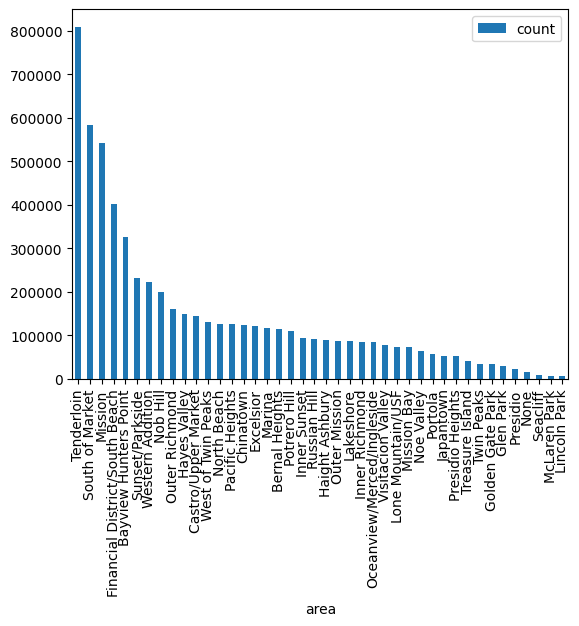

In [51]:
# TODO: axis labels
pandas_df.set_index("area").plot.bar()

In [56]:
# how many calls are there per groups/type
spark.sql("""
SELECT Call_Type_Group, Call_Type, COUNT(*) as count
FROM calls
GROUP BY Call_Type_Group, Call_Type
""").toPandas().head()

,Call_Type_Group,Call_Type,count(1)
0,None,Elevator / Escalator Rescue,7062
1,None,Marine Fire,222
2,None,Aircraft Emergency,1263
3,None,Confined Space / Structure Collapse,286
4,None,Administrative,306


In [58]:
# for each call group, what percentage of calls are represented by the biggest type
spark.sql("""
SELECT Call_Type_Group, MAX(count) / SUM(count)
FROM (
    SELECT Call_Type_Group, Call_Type, COUNT(*) as count
    FROM calls
    GROUP BY Call_Type_Group, Call_Type
)
GROUP BY Call_Type_Group
""").toPandas()

,Call_Type_Group,(max(count) / sum(count))
0,Alarm,0.486623
1,None,0.632953
2,Potentially Life-Threatening,0.942302
3,Non Life-threatening,0.924175
4,Fire,0.383007


In [63]:
from pyspark.sql.functions import col, expr

In [67]:
# same question, using DataFrame API
(spark.table("calls")
 .groupby("Call_Type_Group", "Call_Type")
 .count()
 .groupby("Call_Type_Group")
 .agg(expr("MAX(count) / SUM(count)").alias("perc"))
).toPandas()

,Call_Type_Group,perc
0,Alarm,0.486623
1,None,0.632953
2,Potentially Life-Threatening,0.942302
3,Non Life-threatening,0.924175
4,Fire,0.383007


# Window Functions

In [77]:
# what are three smallest call numbers for each area?
spark.sql("""
SELECT area, Call_Number, row_number() OVER (PARTITION BY area ORDER BY Call_Number ASC) AS rownum
FROM calls
""").where("rownum <= 3").toPandas()

,area,Call_Number,rownum
0,Bayview Hunters Point,1030119,1
1,Bayview Hunters Point,1040031,2
2,Bayview Hunters Point,1040078,3
3,Bernal Heights,1040089,1
4,Bernal Heights,1040245,2
...,...,...,...
121,West of Twin Peaks,1040020,2
122,West of Twin Peaks,1040115,3
123,Western Addition,1030128,1
124,Western Addition,1030128,2
